In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns



plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": 20,
})

import pickle
from xgboost import XGBClassifier
from src.utils import *

with open(f'./investigate_saves_all/results_covid.pickle', 'rb') as f:
    generated_data_covid = pickle.load(f)
with open(f'./investigate_saves_all/results_compas.pickle', 'rb') as f:
    generated_data_compas = pickle.load(f)

In [3]:
def compute_accuracy(generated_data, seed = 0, nest_oracle = 100):
    
    accuracy_wrt_oracle = {}
    for model in generated_data.keys():
        for i in range(len(generated_data[model]["X"])):
            
            X_oracle, y_oracle = generated_data["Oracle"]["X"][i], generated_data["Oracle"]["y"][i]
            
            clf = XGBClassifier(n_estimators=nest_oracle, random_state=seed)
            clf.fit(X_oracle, y_oracle)
            
            X,y = generated_data[model]["X"][i], generated_data[model]["y"][i]
            y_pred = clf.predict(X)

            acc = accuracy_score(y, y_pred)
            
            if model not in accuracy_wrt_oracle.keys():
                accuracy_wrt_oracle[model] = []
            
            accuracy_wrt_oracle[model].append(acc)

    
    sorted_keys = sorted(accuracy_wrt_oracle.keys())

    
    sorted_dict = {key: accuracy_wrt_oracle[key] for key in sorted_keys}


    dict_data = {key: np.mean(value) for key, value in sorted_dict.items() if "easy_ambig" in key or "hard" in key}
    return dict_data, sorted_dict
    

In [4]:
mean_alignment_covid, raw_alignment_covid = compute_accuracy(generated_data_covid, seed = 0, nest_oracle = 100) 
mean_alignment_compas, raw_alignment_compas = compute_accuracy(generated_data_compas, seed = 0, nest_oracle = 100)
    

In [5]:
colors = ["#006D77", "#83C5BE", "#EDF6F9", "#FFDDD2", "#E29578", "#006D77", "#83C5BE", "#EDF6F9", "#FFDDD2", "#E29578"]

def plot_alignment(raw_alignment, ax, name_dataset):
    order_methods = ["gpt4_easy_ambig", "gpt3_easy_ambig", "tvae_easy_ambig", "nflow_easy_ambig","ctgan_easy_ambig" , "gpt4_hard", "gpt3_hard", "tvae_hard", "nflow_hard", "ctgan_hard"]

    # Separate the data into two groups: easy_ambig and hard
    sorted_data = {key: np.mean(raw_alignment[key]) for key in order_methods }
    sorted_data_errors = {key: 1.96*np.std(raw_alignment[key])/np.sqrt(len(raw_alignment[key])) for key in order_methods }

    index = list(range(len(sorted_data)//2)) + list(range(2+ len(sorted_data)//2, 2+ len(sorted_data)))

    hatches = [""]*5 +["."]*5 

    ax.bar(index, list(sorted_data.values()), yerr=list(sorted_data_errors.values()), align='center', color = colors, hatch = hatches, edgecolor="k", lw=1.5)

    ax.set_ylabel("Accuracy", fontsize=30)
    ax.set_xlabel(f"{name_dataset}", fontsize=30)
    ax.xaxis.set_label_position('top')
    ax.set_yticks(np.arange(0, 0.9, 0.1))

    ax.text((index[0] + index[4]) / 2, -0.08, 'Curated', ha='center', fontsize=30)
    ax.text((index[5] + index[-1]) / 2, -0.08, 'Discarded', ha='center', fontsize=30)

    ax.set_xticks([])

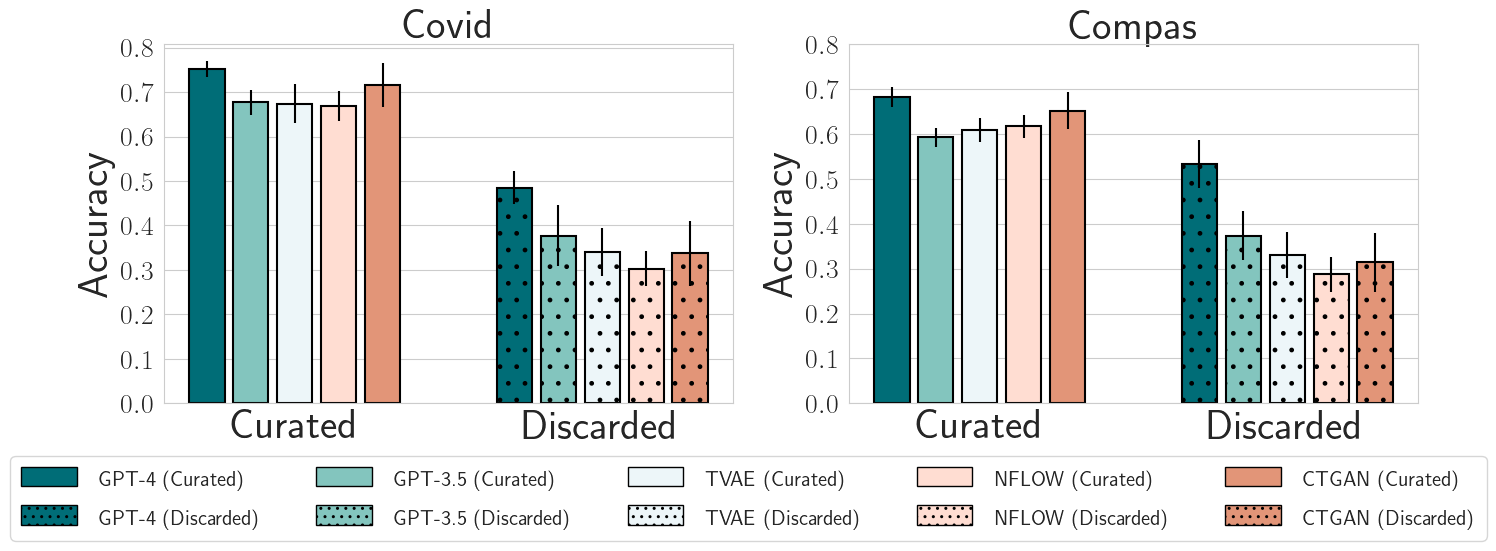

In [6]:

%matplotlib inline

sns.set_style("whitegrid")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


plot_alignment(raw_alignment_covid, ax1, "Covid")
plot_alignment(raw_alignment_compas, ax2, "Compas")


legend_labels = ["GPT-4 (Curated)",  "GPT-3.5 (Curated)",  "TVAE (Curated)",  "NFLOW (Curated)", "CTGAN (Curated)" ,  "GPT-4 (Discarded)",  "GPT-3.5 (Discarded)",  "TVAE (Discarded)",  "NFLOW (Discarded)",  "CTGAN (Discarded)"]

legend_handles = []
import matplotlib.patches as mpatches
hatches = [""]*5 +[".."]*5 

for i,label in enumerate(legend_labels):
    color = colors[i]
    hatch = hatches[i]
    patch = mpatches.Patch(facecolor=color, edgecolor='black', hatch=hatch, label=label)
    legend_handles.append(patch)

new_legend_handles = []
for i in range(len(legend_handles)//2):
    new_legend_handles.append(legend_handles[i])
    new_legend_handles.append(legend_handles[i+5])
legend  = fig.legend(handles=new_legend_handles, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5)
for text in legend.get_texts():
    text.set_fontsize(15)

plt.tight_layout()

plt.show()